In [50]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data
import pandas_datareader as web
import eventstudy as es
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import norm
from numpy import sqrt, abs
from datetime import date, datetime, timedelta
import numpy as np
from statistics import NormalDist
from pyxll import xl_func, plot

In [51]:
tickers2 = pd.read_csv("tickers2.csv").drop(["Headqurter"], axis=1).dropna(axis='rows') # import tickers
sectors = list(tickers2['Sector'].unique()) # returns all the unique industries and removes the last nan valeu

sectors

['Basic Materials',
 'Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Industrials',
 'Real Estate',
 'Technology',
 'Utilities']

In [52]:
tickers2

,Ticker,Sector
0,AXS.L,Basic Materials
1,IOF.L,Basic Materials
2,JAY.L,Basic Materials
3,AAL.L,Basic Materials
4,ALTN.L,Basic Materials
...,...,...
757,NZI.L,Utilities
758,YU.L,Utilities
759,RUR.L,Utilities
760,PHE.L,Utilities


In [53]:

tic = list(tickers2['Ticker']) # returns all the tickers based on an industry
# tic.extend(['VGOV.L','^FTLC'])

In [54]:
le = 14 # days before day 0
ue = 43 # days after day 0
event_date = datetime(2016,6,24) # event date 
start = (event_date - timedelta(days=le)).strftime('%Y-%m-%d')  #start date for event perion plus change of date format
# start = start.strftime('%Y-%m-%d') 
end = (event_date + timedelta(days=ue)).strftime('%Y-%m-%d') #end date for event perion plus change of date format
# end = end.strftime('%Y-%m-%d')
start_date = datetime(2015,1,1) # start date for estimation period
end_date = (start_date + timedelta(days=288)).strftime('%Y-%m-%d') # end date for estimation period




In [55]:
rf = yf.download('VGOV.L', start=start_date, end=end_date, interval='1d')['Adj Close'] # download a 10 year gilt data for estimation period
market = yf.download('^FTLC', start=start_date, end=end_date, interval='1d')['Adj Close'] # download market data for estimation period FTSE 350



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [56]:
market

Date
2014-12-31    3595.300049
2015-01-02    3585.699951
2015-01-05    3520.899902
2015-01-06    3492.500000
2015-01-07    3519.600098
                 ...     
2015-10-09    3562.100098
2015-10-12    3537.899902
2015-10-13    3521.399902
2015-10-14    3484.899902
2015-10-15    3521.600098
Name: Adj Close, Length: 201, dtype: float64

In [57]:
rf = pd.DataFrame(rf).pct_change()[1:] # calculate pct_change for rf
market = pd.DataFrame(market).pct_change()[1:] # calculate pct_change for market


In [58]:
rf.columns = ['rf'] # rename rf column
market.columns = ['market'] # rename market column
market

,market
Date,
2015-01-02,-0.002670
2015-01-05,-0.018072
2015-01-06,-0.008066
2015-01-07,0.007760
2015-01-08,0.022020
...,...
2015-10-09,0.006186
2015-10-12,-0.006794
2015-10-13,-0.004664


In [59]:
returns = yf.download(tic, start_date, end_date, interval = "1d")["Adj Close"] # Download Estimation Period Data 
# market_returns = web.get_data_yahoo("^IXIC", start_date, end_date, interval = 'd').pct_change()[1:]['Close']
# risk_free_returns = web.get_data_yahoo('^TNX', start_date, end_date, interval = 'd').pct_change()[1:]['Close']
# returns = pd.DataFrame(returns).pct_change()[1:]
# returns = returns.drop("AAF.L", axis=1).pct_change()[1:]
# returns = returns.pct_change()[1:]
rows = returns.shape[0] # number of rows
returns.index = pd.to_datetime(returns.index, format = '%d/%m/%Y').strftime('%Y-%m-%d') # change row date format
returns


[*********************100%***********************]  760 of 760 completed

160 Failed downloads:
- AJB.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- CIZ.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- BIG.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- BYIT.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- SAAS.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- IBST.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- SENS.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- BELL.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- NZI.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- MIDW.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- CTEC.L: Data doesn't exist for startDate = 1420066800, endDate = 1444946400
- PURP.L: Data doesn't exist for startDate = 14200

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,4BB.L,4GBL.L,7DIG.L,AAF.L,AAL.L,ABC.L,ABDX.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,AJB.L,ALAI.L,ALFA.L,ALT.L,ALTN.L,AMGO.L,AML.L,AMS.L,ANCR.L,ANGS.L,AO.L,AOM.L,APF.L,APH.L,APTA.L,APTD.L,ARC.L,AREC.L,ARIX.L,ASC.L,ASCL.L,ASHM.L,ASLI.L,AST.L,AT.L,ATG.L,ATOM.L,ATQT.L,AUTO.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AWE.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BAKK.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BELL.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIFF.L,BIG.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BKS.L,BLND.L,BLOE.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOWL.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVX.L,BVXP.L,BWNG.L,BWY.L,BYG.L,BYIT.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CAY.L,CBG.L,CBX.L,CCC.L,CCEP.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CCS.L,CER.L,CGS.L,CGT.L,CHG.L,CHLL.L,CINE.L,CIR.L,CIZ.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CLX.L,CMCX.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,CORO.L,COST.L,CPG.L,CPH2.L,CPI.L,CRDA.L,CREO.L,CRST.L,CRW.L,CSFS.L,CSN.L,CSP.L,CTEA.L,CTEC.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DARK.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DEST.L,DFS.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNL.L,DNLM.L,DNM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DWF.L,DX.L,DXRX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,ECSC.L,EDIN.L,EDL.L,EDR.L,EGL.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENOG.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ESYS.L,ETP.L,ETX.L,EVG.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAB.L,FAN.L,FCH.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FNX.L,FORT.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GABI.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENF.L,GENI.L,GENL.L,GETB.L,GFRD.L,GHH.L,GHT.L,GILD.L,GLE.L,GLO.L,GMR.L,GNS.L,GOOD.L,GPOR.L,GRC.L,GRG.L,GRI.L,GSK.L,GTC.L,GYM.L,HAS.L,HAT.L,HBR.L,HDT.L,HEAD.L,HEFT.L,HEMO.L,HFD.L,HFEL.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSS.L,HSV.L,HTCF.L,HTG.L,HTWS.L,HUR.L,HWDN.L,HYVE.L,I3E.L,IBST.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IHP.L,IMB.L,IME.L,IMI.L,IMM.L,IMMO.L,INCH.L,INF.L,ING.L,INHC.L,INPP.L,INS.L,INSG.L,INX.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITIM.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KGH.L,KIE.L,KIST.L,KLR.L,KMK.L,KNB.L,KNOS.L,KOO.L,LAND.L,LBE.L,LBG.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LOOP.L,LSAI.L,LSL.L,LST.L,LTG.L,LUCE.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MAST.L,MCB.L,MCKS.L,MCL.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MGP.L,MHC.L,MIDW.L,MIRI.L,MKS.L,MNDI.L,MNG.L,MNZS.L,MODE.L,MONY.L,MOS.L,MOTR.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTEC.L,MTO.L,MTPH.L,MTRO.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NCYT.L,NET.L,NEX.L,NFC.L,NFX.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NWOR.L,NXR.L,NXT.L,NZI.L,OBC.L,OBD.L,OCDO.L,OCTP.L,ODX.L,OKYO.L,OMG.L,OMIP.L,ONC.L,ONT.L,OPTI.L,ORCA.L,ORCP.L,ORPH.L,OSB.L,OSI.L,OTAQ.L,OTB.L,OTMP.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PBEE.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEBB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,PNPL.L,POG.L,POLB.L,POLR.L,POS.L,PPC.L,PPP.L,PRES.L,PRM.L,PRSM.L,PRU.L,PRV.L,PSDL.L,PSON.L,PTRO.L,PTY.L,PURP.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QLT.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RBG.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REDX.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROQ.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAAS.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBDS.L,SBI.L,SBRE.L,SBRY.L,SBTX.L,SCIR.L,SCLP.L,SCP.L,SCRF.L,SCS.L,SCT.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDX.L,SDY.L,SEEN.L,SENS.L,SERE.L,SFOR.L,SFR.L,SFTL.IL,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHR

In [60]:
# rf = pd.read_csv("10y.csv")
# rf.index = list(rf['Date'])
# rf


In [61]:
pd.set_option("display.max_rows", 20) # change max display of rows
pd.set_option("display.max_columns", None) # change max display of columns

In [62]:
isn = dict(returns.isnull().mean().transpose()) # check how many null values are there column wise 
for sym, val in isn.items():
    if returns.shape[0]==rows and val>0: # loop to check whether dates are the same number and if there are null values in the dataset
        returns.drop([sym],axis=1,inplace=True) # if found drops corresponding ticker
    
    # print(sym, val)
returns

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [63]:
returns = returns.pct_change()[1:] # returns of the dataset
returns


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [64]:
for i in range(len(returns.columns[:])): # loop to get excess returns r(it)-E[rf]
    returns[returns.columns[i]] = returns[returns.columns[i]] - rf['rf'].mean()
returns.dropna()

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [65]:
returns = returns.dropna() # drops na values
x = market['market'] # independent variable for regression
x_sm = sm.add_constant(x) # add constant
values = pd.DataFrame(index=['0','1'], columns=list(returns.columns)[:]) # create dataframe to store alpha and beta 

In [66]:

for i in range(len(returns.columns[:])): # run regression and store alpha and beta in values dataframe 0=alpha, 1=beta
    returns = returns.dropna()
    y = list(returns[returns.columns[i]])
    model = sm.OLS(y,x_sm)
    results = model.fit()
    values.iat[0,i] = results.params[0]
    values.iat[1,i] = results.params[1]
  

In [67]:
values

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
0,-0.003496,7.533176,0.000171,0.000734,-0.001911,-0.002037,0.00121,-0.000016,0.001575,0.002048,0.001188,0.003037,0.003268,-0.000225,0.000422,0.008625,0.001026,0.001223,0.000648,-0.000303,0.000861,-0.000593,0.003569,-0.001246,-0.001154,-0.001561,0.001125,0.00206,-0.00229

In [68]:
ls = list(returns.columns) # return a list of columns from returns dataframe (tickers)
ls.append('^FTLC')
event = yf.download(ls,start, end, interval='1d').pct_change()[1:]['Adj Close'] # download event data for tickers and market 
event.index = pd.to_datetime(event.index, format = '%d/%m/%Y').strftime('%Y-%m-%d')
# if event.shape[0]%2==0:
ix = np.arange(-int(event.index.get_loc('2016-06-24')),int(int(event.shape[0] - event.index.get_loc('2016-06-24')))) # change dates to a day timeframe counting down to 0(event day) and up after the event
event.index = ix # change event dataframe index to countdown

event



[*********************100%***********************]  588 of 588 completed


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.0,0.000000,-0.023612,0.001139,0.000000,-0.035285,-0.012289,0.0,0.017578,0.000000,-0.033976,-0.026316,0.000000,0.0,-0.002488,-0.047619,-0.030172,-0.007576,-0.009573,-0.003171,0.000000,-0.021418,0.020377,-0.013889,0.000000,0.012500,-0.007663,0.000000,-0.013150

In [69]:
event.isna().values.any()
event


,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.0,0.000000,-0.023612,0.001139,0.000000,-0.035285,-0.012289,0.0,0.017578,0.000000,-0.033976,-0.026316,0.000000,0.0,-0.002488,-0.047619,-0.030172,-0.007576,-0.009573,-0.003171,0.000000,-0.021418,0.020377,-0.013889,0.000000,0.012500,-0.007663,0.000000,-0.013150

In [70]:
ar_returns = pd.DataFrame(index = ix, columns =list(event.columns)) # create abnormal returns dataframe
for i in range(len(event.columns[:-1])):
    returns = returns.dropna()
    ar_returns[event.columns[i]] = event[event.columns[i]] - (values.iat[0,i] + values.iat[1,i]*event['^FTLC']) #calculates abnormal returns (stock returns - normal returns )

InvalidIndexError: (slice(None, None, None), None)

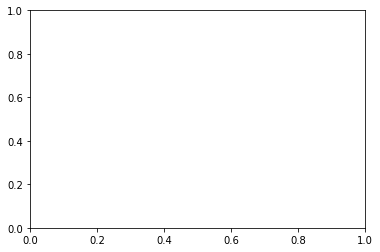

In [100]:
ar_returns
plt.plot(ar_returns.index, ar_returns)

In [72]:
ar_returns.std(axis=0)
asd = ar_returns/ar_returns.std(axis=0)
asd

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L,^FTLC
-10,0.078624,0.732943,-0.095216,0.493235,0.087893,0.024402,-0.161387,9.418024e+15,0.862572,-0.604147,-1.396451,-0.423192,0.340486,0.385773,0.193468,-0.727822,-1.638886,-0.063571,-0.244497,1.060756,0.139636,-0.129687,1.188878,0.170990,0.040059,0.492826,-0.021256,0.

In [73]:
ar_returns.describe()

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,4.100000e+01,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,4

In [74]:
ar_returns.drop(['^FTLC'], axis=1, inplace=True) # removes market data column
aar = ar_returns.mean(axis=1) # calculates the average of the rows
aar = pd.DataFrame(aar,columns = ['AAR']) #creates dataframe of aar
aar

,AAR
-10,0.017769
-9,0.000639
-8,0.012667
-7,-0.026130
-6,-0.014870
...,...
26,-0.001380
27,-0.001770
28,-0.008772
29,-0.039557


In [75]:
plt.close("all")


In [76]:
car = pd.DataFrame(index = ix, columns =list(event.columns[:-1])) # create car dataframe
car

,0QHX.IL,0RG4.IL,0RMV.IL,3IN.L,7DIG.L,AAL.L,ABC.L,ACC.L,ACSO.L,ACT.L,ADM.L,ADME.L,ADT.L,AEO.L,AEP.L,AFC.L,AFRN.L,AGL.L,AGR.L,AGT.L,AGY.L,AHT.L,AIR.L,ALAI.L,ALT.L,ALTN.L,AMS.L,ANCR.L,AO.L,APF.L,APH.L,APTD.L,ARC.L,ASC.L,ASHM.L,AST.L,ATQT.L,AV.L,AVCT.L,AVO.L,AVON.L,AVV.L,AXS.L,AZN.L,BA.L,BAB.L,BAG.L,BARC.L,BATS.L,BBB.L,BBOX.L,BBSN.L,BBY.L,BCPT.L,BDEV.L,BEZ.L,BGEO.L,BGO.L,BIDS.L,BIOM.L,BIRD.L,BISI.L,BKG.L,BLND.L,BLTG.L,BLVN.L,BMK.L,BMY.L,BNZL.L,BOIL.L,BONH.L,BOO.L,BOOT.L,BOR.L,BOY.L,BP-A.L,BP-B.L,BP.L,BPET.L,BRBY.L,BREI.L,BRK.L,BRLA.L,BRSC.L,BRW.L,BSIF.L,BT-A.L,BVIC.L,BVXP.L,BWNG.L,BWY.L,BYG.L,C4XD.L,CAD.L,CAL.L,CAM.L,CAML.L,CAPC.L,CAR.L,CARD.L,CARR.L,CASP.L,CAU.L,CBG.L,CCC.L,CCP.L,CCPA.L,CCPC.L,CCPE.L,CCPG.L,CGS.L,CGT.L,CHG.L,CINE.L,CIR.L,CKN.L,CKT.L,CLCO.L,CLG.L,CLI.L,CLIG.L,CLIN.L,CML.L,CNA.L,CNC.L,CNE.L,CNIC.L,CNS.L,COA.L,COG.L,COST.L,CPG.L,CPI.L,CRDA.L,CRST.L,CRW.L,CSN.L,CTEA.L,CTH.L,CTO.L,CTY.L,CWK.L,CWR.L,CYAN.L,D4T4.L,DBOX.L,DCD.L,DDDD.L,DELT.L,DEMG.L,DGE.L,DIA.L,DLAR.L,DLG.L,DLN.L,DMTR.L,DNLM.L,DOM.L,DOTD.L,DPH.L,DPLM.L,DRX.L,DSCV.L,DSG.L,DTY.L,DVO.L,DX.L,EAH.L,EBQ.L,ECHO.L,ECK.L,ECM.L,EDIN.L,EDL.L,EDR.L,EKF.L,ELCO.L,ELM.L,EMAN.L,EMIS.L,ENQ.L,ENW.L,EOG.L,EPWN.L,ERGO.L,ERM.L,ESNT.L,ESP.L,ETX.L,EVR.L,EWI.L,EYE.L,EZJ.L,FAN.L,FDBK.L,FDEV.L,FDM.L,FDP.L,FEET.L,FERG.L,FEVR.L,FGP.L,FLO.L,FLX.L,FOUR.L,FOXT.L,FSFL.L,FSTA.L,FSV.L,FTC.L,FUM.L,FUTR.L,GAMA.L,GATC.L,GAW.L,GBG.L,GCM.L,GDR.L,GDWN.L,GEMD.L,GENL.L,GFRD.L,GHH.L,GHT.L,GLE.L,GMR.L,GNS.L,GOOD.L,GRG.L,GRI.L,GSK.L,GTC.L,HAS.L,HAT.L,HDT.L,HEAD.L,HEFT.L,HFD.L,HFG.L,HGT.L,HICL.L,HIK.L,HILS.L,HL.L,HLCL.L,HLMA.L,HMSO.L,HNE.L,HOC.L,HSBA.L,HSL.L,HSP.L,HSV.L,HTCF.L,HTG.L,HUR.L,HWDN.L,HYVE.L,ICGT.L,ICP.L,IDE.L,IDEA.L,IDOX.L,IEM.L,IGAS.L,IGG.L,IGP.L,IHC.L,IHG.L,IMB.L,IME.L,IMI.L,IMM.L,INCH.L,INF.L,ING.L,INPP.L,INS.L,IOF.L,IOG.L,IOM.L,IPF.L,IPO.L,IPX.L,IQE.L,IQG.L,ITM.L,ITRK.L,ITV.L,IUG.L,IXI.L,JAY.L,JD.L,JDG.L,JDW.L,JHD.L,JLEN.L,JMAT.L,JMG.L,JUP.L,JUSC.L,JWNG.L,KAPE.L,KBT.L,KCT.L,KGF.L,KIE.L,KLR.L,KMK.L,LAND.L,LBOW.L,LGEN.L,LIO.L,LLOY.L,LMP.L,LOOK.L,LSAI.L,LSL.L,LTG.L,LVCG.L,MAB.L,MAB1.L,MAI.L,MARS.L,MCB.L,MCKS.L,MCLS.L,MCRO.L,MCT.L,MDZ.L,MER.L,MGAM.L,MGGT.L,MGNS.L,MHC.L,MKS.L,MNDI.L,MNZS.L,MONY.L,MOS.L,MPE.L,MRIT.L,MRO.L,MSLH.L,MSYS.L,MTC.L,MTO.L,MTPH.L,MTVW.L,MUL.L,N4P.L,NAH.L,NANO.L,NAR.L,NCC.L,NCYF.L,NET.L,NEX.L,NFC.L,NG.L,NICL.L,NNN.L,NOG.L,NRR.L,NSCI.L,NTOG.L,NTQ.L,NUM.L,NWF.L,NXR.L,NXT.L,OBC.L,OCDO.L,ODX.L,OMG.L,OMIP.L,OPTI.L,ORCP.L,ORPH.L,OSB.L,OXB.L,OXIG.L,PAG.L,PANR.L,PAY.L,PCIP.L,PDG.L,PDL.L,PEB.L,PEN.L,PETS.L,PFD.L,PFG.L,PGR.L,PHAR.L,PHE.L,PHNX.L,PHP.L,PHTM.L,PIN.L,PIP.L,PMG.L,PNN.L,POG.L,POLR.L,POS.L,PPC.L,PRES.L,PRM.L,PRU.L,PRV.L,PSON.L,PTY.L,PXEN.L,PXS.L,PYC.L,PZC.L,QFI.L,QQ.L,QRT.L,QTX.L,QXT.L,RAT.L,RAV.L,RBD.L,RCDO.L,RCH.L,RCN.L,RDT.L,RDW.L,RE.L,REC.L,RECI.L,REDD.L,REL.L,RENE.L,RICA.L,RIO.L,RIV.L,RKH.L,RM.L,RMG.L,RMV.L,RNK.L,RNO.L,ROR.L,RPS.L,RR.L,RSW.L,RTN.L,RTO.L,RUA.L,RUR.L,RWA.L,RWI.L,RWS.L,SAA.L,SAE.L,SAFE.L,SAGA.L,SAL.L,SAR.L,SAVE.L,SBRY.L,SCIR.L,SCLP.L,SCP.L,SDI.L,SDR.L,SDRC.L,SDRY.L,SDY.L,SFR.L,SGC.L,SGE.L,SGRO.L,SHB.L,SHEL.L,SHI.L,SHRS.L,SIR.L,SLI.L,SMDS.L,SMIF.L,SMIN.L,SMRT.L,SMS.L,SMWH.L,SN.L,SNG.L,SNR.L,SNWS.L,SOLI.L,SOU.L,SPA.L,SPE.L,SPI.L,SPO.L,SPT.L,SPX.L,SQZ.L,SRP.L,SRT.L,SSE.L,SSPG.L,STAF.L,STAN.L,STB.L,STJ.L,STVG.L,SUN.L,SUS.L,SVS.L,SVT.L,SWEF.L,SWG.L,SXS.L,SYNC.L,SYNT.L,SYS.L,SYS1.L,TATE.L,TED.L,TEK.L,TEP.L,TERN.L,TET.L,TFIF.L,TIDE.L,TLW.L,TLY.L,TMG.L,TOWN.L,TPK.L,TPT.L,TRAK.L,TRB.L,TRCS.L,TRD.L,TRI.L,TRIN.L,TRP.L,TRX.L,TSCO.L,TST.L,TSTL.L,TTG.L,TUNG.L,TW.L,TYMN.L,UJO.L,UKCM.L,UKOG.L,ULE.L,ULS.L,ULVR.L,UTG.L,UU.L,VAL.L,VCT.L,VLG.L,VLS.L,VLX.L,VOD.L,VOG.L,VP.L,VSVS.L,VTC.L,VTU.L,WAND.L,WEIR.L,WG.L,WIL.L,WIN.L,WINE.L,WKP.L,WPP.L,WTB.L,XAR.L,YGEN.L,YNGA.L,YOU.L,ZIN.L,ZOO.L,ZPHR.L,ZTF.L,ZYT.L
-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [77]:
for i in range(len(event.columns[:-1])):
    returns = returns.dropna()
    car[event.columns[i]] = ar_returns[returns.columns[i]].cumsum() # calculates car values 

In [78]:
i = (ar_returns.var(axis=0)/(20**2)).sum()
i

0.542656965921085

In [79]:
caar = pd.DataFrame(car.mean(axis=1), columns=['CAAR']) # creates caar dataframe and calculates caar
caar

,CAAR
-10,0.017769
-9,0.018408
-8,0.031075
-7,0.004945
-6,-0.009925
...,...
26,-0.619198
27,-0.620968
28,-0.629740
29,-0.669297


In [80]:
# caar['Variance'] = car.var(axis=1)
# caar['t-stat'] = (caar['CAAR']/(caar['Variance']**(1/2)))*(float(car.shape[1])**(1/2))
caar['Variance'] = ""
for i in range(len(ar_returns.index)): # calculates variance of caar
    caar.iat[i,1]=((ar_returns.var(axis=0).sum())/(ar_returns.shape[1]**2))*(caar.index[i]-caar.index[0]+1) 
caar = caar.astype(float) # changes values to float 
   
caar['t-stat'] = (caar['CAAR']/(caar['Variance']**(1/2))) # calculates t-stat for caar
caar['p-value'] = norm.cdf(caar['t-stat']) # calculates p-value for caar
# caar['p-value'] = ss.t.sf(abs(caar['t-stat']),float(caar.shape[1]-2))
caar['Significance'] = ""
for i in range(len(caar.index)): # adds asterics for signifficance
    if caar.iat[i,3]<=0.001:
        caar.iat[i,4]="***"
    elif 0.001<caar.iat[i,3]<=0.01:
        caar.iat[i,4]="**"
    elif 0.01<caar.iat[i,3]<=0.05:
        caar.iat[i,4]="*"
    else:
        caar.iat[i,4]=""
caar['95% CI'] = ""
for i in range(len(ar_returns.index)): # calculates 95% Confidence Interval
    caar.iat[i,5] = NormalDist(mu=0, sigma=sqrt(caar.iat[i,1])).inv_cdf(0.05)
caar['99% CI'] = ""
for i in range(len(ar_returns.index)): # Calculates 99% Confidence Interval
    caar.iat[i,6] = NormalDist(mu=0, sigma=sqrt(caar.iat[i,1])).inv_cdf(0.01)

In [81]:

# caar.iat[1,1]=(ar_returns.var(axis=0).sum())/((ar_returns.shape[1]**2)*(caar.index[1]-caar.index[0]+1))
caar[7:14]


,CAAR,Variance,t-stat,p-value,Significance,95% CI,99% CI
-3,-0.124264,0.005040,-1.750427,0.040022,*,-0.116769,-0.165148
-2,-0.145144,0.005670,-1.927632,0.026950,*,-0.123852,-0.175166
-1,-0.177440,0.006300,-2.235617,0.012688,*,-0.130551,-0.184641
0,-0.158563,0.006929,-1.904810,0.028402,*,-0.136924,-0.193654
1,-0.151392,0.007559,-1.741241,0.040821,*,-0.143012,-0.202265
2,-0.206424,0.008189,-2.281040,0.011273,*,-0.148852,-0.210524
3,-0.274588,0.008819,-2.923900,0.001728,**,-0.154471,-0.218471


In [82]:
aar['Variance'] = ar_returns.var(axis=1) # calculates variance of aar 
aar['t-stat'] = (aar['AAR']/(aar['Variance']**(1/2)))*(float(car.shape[1])**(1/2)) # calculates t-stat for aar
# aar['p-value'] = ss.t.sf(abs(aar['t-stat']),float(car.shape[1]-2))
aar['p-value'] = norm.cdf(aar['t-stat']) # calculates p-value for aar
aar['Significance'] = ""
for i in range(len(aar.index)): # adds asterics for signifficance
    if aar.iat[i,3]<=0.001:
        aar.iat[i,4]="***"
    elif 0.001<aar.iat[i,3]<=0.01:
        aar.iat[i,4]="**"
    elif 0.01<aar.iat[i,3]<=0.05:
        aar.iat[i,4]="*"
    else:
        aar.iat[i,4]=""

In [83]:
aar

,AAR,Variance,t-stat,p-value,Significance
-10,0.017769,0.198686,0.965814,0.832931,
-9,0.000639,0.038020,0.079453,0.531664,
-8,0.012667,0.275427,0.584778,0.720651,
-7,-0.026130,0.349966,-1.070162,0.142273,
-6,-0.014870,0.010778,-3.470383,0.000260,***
...,...,...,...,...,...
26,-0.001380,0.011506,-0.311723,0.377625,
27,-0.001770,0.001390,-1.149908,0.125091,
28,-0.008772,0.052272,-0.929602,0.176289,
29,-0.039557,0.924012,-0.997025,0.159376,


In [84]:
pd.set_option("display.max_columns", None)

In [85]:
# pd.set_option("display.max_rows", 15)

In [86]:
data = pd.concat([aar,caar], axis=1) # combines aar and caar together
data.transpose()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
AAR,0.017769,0.000639,0.012667,-0.02613,-0.01487,-0.030941,-0.062183,-0.021214,-0.020881,-0.032296,0.018877,0.007171,-0.055031,-0.068164,-0.047281,-0.028602,0.001402,-0.025901,-0.001385,-0.028289,-0.0257,-0.029136,-0.007968,-0.006368,-0.005588,-0.013641,-0.018928,-0.012955,-0.017748,-0.001601,-0.021756,-0.005634,-0.014504,-0.015465,-0.004265,-0.011915,-0.00138,-0.00177,-0.008772,-0.039557,-0.023072
Variance,0.198686,0.03802,0.275427,0.349966,0.010778,0.791983,2.508507,0.197316,0.27964,0.729262,1.650416,1.109046,2.153344,3.119757,1.463733,0.614277,0.015842,0.078485,0.024965,0.615269,0.531892,1.02355,0.12264,0.05637,0.05991,0.133251,0.253263,0.114012,0.269745,0.030567,0.197777,0.06222,0.140397,0.275634,0.025389,0.116575,0.011506,0.00139,0.052272,0.924012,0.451651
t-stat,0.965814,0.079453,0.584778,-1.070162,-3.470383,-0.842369,-0.951225,-1.157059,-0.956679,-0.916273,0.356002,0.164975,-0.908597,-0.935007,-0.946838,-0.884149,0.269865,-2.239995,-0.212398,-0.873783,-0.853761,-0.697733,-0.55127,-0.649851,-0.553168,-0.905409,-0.911261,-0.929588,-0.827946,-0.221839,-1.185277,-0.54728,-0.937839,-0.713671,-0.648473,-0.845514,-0.311723,-1.149908,-0.929602,-0.997025,-0.83178
p-value,0.832931,0.531664,0.720651,0.142273,0.00026,0.199791,0.170745,0.123624,0.169365,0.179762,0.639081,0.565518,0.181782,0.174892,0.171861,0.188308,0.606368,0.012546,0.415898,0.191118,0.196619,0.242672,0.290724,0.257894,0.290074,0.182624,0.181079,0.176292,0.203851,0.41222,0.117954,0.292093,0.174164,0.237715,0.25834,0.198912,0.377625,0.125091,0.176289,0.159376,0.202767
Significance,,,,,***,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,,,
CAAR,0.017769,0.018408,0.031075,0.004945,-0.009925,-0.040867,-0.10305,-0.124264,-0.145144,-0.17744,-0.158563,-0.151392,-0.206424,-0.274588,-0.321869,-0.35047,-0.349068,-0.37497,-0.376355,-0.404644,-0.430343,-0.459479,-0.467447,-0.473816,-0.479404,-0.493045,-0.511974,-0.524929,-0.542677,-0.544278,-0.566035,-0.571669,-0.586173,-0.601638,-0.605903,-0.617818,-0.619198,-0.620968,-0.62974,-0.669297,-0.69237
Variance,0.00063,0.00126,0.00189,0.00252,0.00315,0.00378,0.00441,0.00504,0.00567,0.0063,0.006929,0.007559,0.008189,0.008819,0.009449,0.010079,0.010709,0.011339,0.011969,0.012599,0.013229,0.013859,0.014489,0.015119,0.015749,0.016379,0.017009,0.017639,0.018269,0.018899,0.019529,0.020159,0.020788,0.021418,0.022048,0.022678,0.023308,0.023938,0.024568,0.025198,0.025828
t-stat,0.707951,0.518612,0.714825,0.098511,-0.176849,-0.664722,-1.551827,-1.750427,-1.927632,-2.235617,-1.90481,-1.741241,-2.28104,-2.9239,-3.311149,-3.490894,-3.373118,-3.521318,-3.44006,-3.604983,-3.741545,-3.903012,-3.883419,-3.853445,-3.82012,-3.852527,-3.925646,-3.952455,-4.015023,-3.959184,-4.05049,-4.026383,-4.065503,-4.11094,-4.080508,-4.102558,-4.055778,-4.013495,-4.017673,-4.21633,-4.308157
p-value,0.760512,0.697984,0.762641,0.539237,0.429814,0.253114,0.060352,0.040022,0.02695,0.012688,0.028402,0.040821,0.011273,0.001728,0.000465,0.000241,0.000372,0.000215,0.000291,0.000156,0.000091,0.000048,0.000051,0.000058,0.000067,0.000058,0.000043,0.000039,0.00003,0.000038,0.000026,0.000028,0.000024,0.00002,0.000022,0.00002,0.000025,0.00003,0.000029,0.000012,0.000008
Significance,,,,,,,,*,*,*,*,*,*,**,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***,***


In [87]:
# data.to_latex('main.tex')

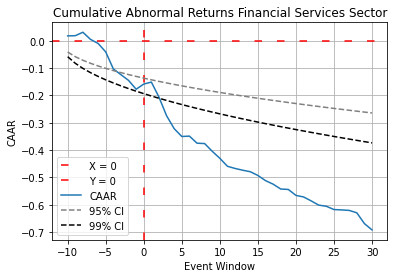

In [88]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,caar['CAAR'],linewidth=1.5, label='CAAR')#plots caar values 
ax.plot(caar.index.values,caar['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,caar['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("CAAR") # label y axis
ax.set_title(f'Cumulative Abnormal Returns {sectors[5]} Sector') # label table
ax.grid() # add grid to table
plt.show()

Nonparametric data

In [89]:
returnsNP = yf.download(ls, start, end, interval = "1d")["Adj Close"] # Download Estimation Period Data 
rows = returnsNP.shape[0] # number of rows
returnsNP.index = pd.to_datetime(returnsNP.index, format = '%d/%m/%Y').strftime('%Y-%m-%d') # change row date format

isn = dict(returnsNP.isnull().mean().transpose()) # check how many null values are there column wise 
for sym, val in isn.items():
    if returnsNP.shape[0]==rows and val>0: # loop to check whether dates are the same number and if there are null values in the dataset
        returnsNP.drop([sym],axis=1,inplace=True) # if found drops corresponding ticker
    
    
returnsNP = returnsNP.pct_change()[1:]
returnsNP.index = np.arange(-returnsNP.shape[0]+(returnsNP.shape[0]-1-returnsNP.index.get_loc('2016-06-24')+1),returnsNP.shape[0]-1-returnsNP.index.get_loc('2016-06-24')+1,dtype=object)

ar_returns = pd.DataFrame(index = list(returnsNP.index), columns =list(returnsNP.columns)) # create abnormal returns dataframe
for i in range(len(ar_returns.columns[:-1])):
    returnsNP = returnsNP.dropna()
    ar_returns[ar_returns.columns[i]] = returnsNP[ar_returns.columns[i]] - (values.iat[0,i] + values.iat[1,i]*returnsNP['^FTLC']) #calculates abnormal returns (stock returns - normal returns )

ar_returns.drop(['^FTLC'], axis=1, inplace=True) # removes market data column

ar_returns_sign = pd.DataFrame(index = list(ar_returns.index), columns =['t-sign', 'p-value', '95% CI','99% CI'])

ar_returns = ar_returns.transpose()

[*********************100%***********************]  588 of 588 completed


In [90]:
# ar_returns_sign[['t-sign', 'p-value', '95% CI','99% CI']] = None

In [91]:
ar_returns_sign = ar_returns_sign.transpose()
for i in range(len(ar_returns_sign.columns)):
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('t-sign'),i] = ((len(ar_returns[ar_returns[ar_returns.columns[i]]>0.0])/(ar_returns.shape[0]))-0.5)*(sqrt(ar_returns.shape[0])/0.5)
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('p-value'),i] = norm.cdf(ar_returns_sign.iat[0,i])
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('95% CI'),i] = NormalDist(mu=0, sigma=1).inv_cdf(0.05)
    ar_returns_sign.iat[ar_returns_sign.index.get_loc('99% CI'),i] =NormalDist(mu=0, sigma=1).inv_cdf(0.01)

    
        
ar_returns_sign = ar_returns_sign.transpose()
ar_returns_sign = ar_returns_sign.astype(float)
# ar_returns_sign['p-value'] = norm.cdf(ar_returns_sign['t-stat'])
# ar_returns_sign = ar_returns_sign[ar_returns_sign.index.get_loc(-30):]
ar_returns_sign[7:14]


,t-sign,p-value,95% CI,99% CI
-3,-4.746558,1.034537e-06,-1.644854,-2.326348
-2,-1.444605,7.428449e-02,-1.644854,-2.326348
-1,0.454019,6.750923e-01,-1.644854,-2.326348
0,-11.598111,2.106366e-31,-1.644854,-2.326348
1,-10.442428,7.934982e-26,-1.644854,-2.326348
2,2.104995,9.823541e-01,-1.644854,-2.326348
3,1.527153,9.366386e-01,-1.644854,-2.326348


In [92]:
len(ar_returns[ar_returns[ar_returns.columns[4]]>0.0])
ar_returns.shape[0]

587

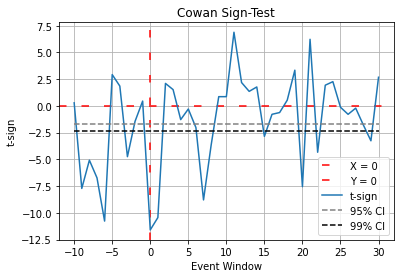

In [93]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,ar_returns_sign['t-sign'],linewidth=1.5, label='t-sign')#plots caar values 
ax.plot(caar.index.values,ar_returns_sign['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,ar_returns_sign['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("t-sign") # label y axis
ax.set_title('Cowan Sign-Test') # label table
ax.grid() # add grid to table
plt.show()

In [94]:
rank = ar_returns.rank(axis=1)
rank
ar_returns_rank = pd.DataFrame(columns = rank.columns.tolist(), index= ['rank', 's(rank)', 't-rank', 'p-value','95% CI','99% CI'])
ar_returns_rank
for i in range(ar_returns_rank.shape[1]):
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('rank'),i] = (rank[rank.columns[i]].sum()-(rank.shape[0]*(rank.shape[1]+1)/2))/(rank.shape[0])
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('s(rank)'),i] = sqrt((ar_returns_rank.pow(2, axis=1).sum(axis=1)[0])/(rank.shape[0]))
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('t-rank'),i] = ar_returns_rank.iat[0,i]/ar_returns_rank.iat[1,i]
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('p-value'),i] = norm.cdf(ar_returns_rank.iat[2,i])
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('95% CI'),i] = NormalDist(mu=0, sigma=1).inv_cdf(0.05)
    ar_returns_rank.iat[ar_returns_rank.index.get_loc('99% CI'),i] =NormalDist(mu=0, sigma=1).inv_cdf(0.01)

In [95]:
ar_returns_rank = ar_returns_rank.transpose()



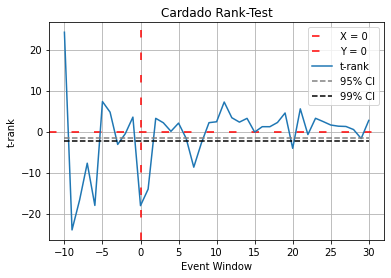

In [96]:
fig, ax = plt.subplots()
ax.axvline(x=0, color='r', linestyle=(0,(5,10)), label='X = 0')# plot dashed line for x=0
ax.axhline(y=0, color='r', linestyle=(0,(5,10)), label='Y = 0')# plot dashed line for y=0
# plt.scatter(aar.index.values,aar['AAR'],s=30,label='AAR')
# plt.plot(aar.index.values,aar['AAR'],linestyle='solid',linewidth=3)
# plt.scatter(aar.index.values,caar['CAAR'],s=30,label='CAAR')
ax.plot(caar.index.values,ar_returns_rank['t-rank'],linewidth=1.5, label='t-rank')#plots caar values 
ax.plot(caar.index.values,ar_returns_rank['95% CI'],linewidth=1.5, linestyle='dashed', color='grey', label='95% CI') # plots 95% CI
ax.plot(caar.index.values,ar_returns_rank['99% CI'],linewidth=1.5, linestyle='dashed', color='black', label='99% CI')# plots 95% CI
ax.legend(fancybox=True) # fancybox for index
ax.set_xlabel("Event Window") # label x axis
ax.set_ylabel("t-rank") # label y axis
ax.set_title('Cardado Rank-Test') # label table
ax.grid() # add grid to table
plt.show()


Nonparametric data

In [97]:
combined_data = pd.DataFrame()


In [98]:
combined_data = pd.concat([combined_data,caar])
combined_data

,CAAR,Variance,t-stat,p-value,Significance,95% CI,99% CI
-10,0.017769,0.000630,0.707951,0.760512,,-0.041284,-0.058389
-9,0.018408,0.001260,0.518612,0.697984,,-0.058384,-0.082574
-8,0.031075,0.001890,0.714825,0.762641,,-0.071506,-0.101132
-7,0.004945,0.002520,0.098511,0.539237,,-0.082568,-0.116778
-6,-0.009925,0.003150,-0.176849,0.429814,,-0.092314,-0.130561
...,...,...,...,...,...,...,...
26,-0.619198,0.023308,-4.055778,0.000025,***,-0.251121,-0.355165
27,-0.620968,0.023938,-4.013495,0.000030,***,-0.254492,-0.359932
28,-0.629740,0.024568,-4.017673,0.000029,***,-0.257819,-0.364638
29,-0.669297,0.025198,-4.216330,0.000012,***,-0.261103,-0.369283
